In [1]:
!pip install --upgrade --ignore-installed kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 6.0 MB/s 
     |████████████████████████████████| 155 kB 64.3 MB/s 
     |████████████████████████████████| 247 kB 70.7 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 140 kB 71.2 MB/s 
     |████████████████████████████████| 78 kB 8.7 MB/s 
     |████████████████████████████████| 61 kB 104 kB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=1377cc3f30118b0d7b8f92fd36d315a7b9e3cc77a07211f2933649dba9f7adea
  Stored in directory: /root/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minahil1","key":"3c54af3ad0462451c498367f847d9f2f"}'}

In [3]:
!mkdir ~/.kaggle #created at root folder in colab

In [4]:
#copy
!cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# example
!kaggle datasets download -d puneet6060/intel-image-classification

100% 345M/346M [00:15<00:00, 22.3MB/s]
100% 346M/346M [00:15<00:00, 22.9MB/s]


In [7]:
#unzip dataset in colab session
!unzip -q intel-image-classification.zip # -q for quiet 

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# copy zipped dataset into your drive
!cp "intel-image-classification.zip" /content/drive/MyDrive/

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import os
from os import walk

import tensorflow as tf
tf.random.set_seed(0)
tf.keras.backend.clear_session()

In [11]:
classes = {"buildings":0,"forest":1,"glacier":2, "mountain":3, "sea":4, "street":5}
dir_train =  "/content/seg_train/seg_train"
dir_test = "/content/seg_test/seg_test"
dir_pred = "/content/seg_pred/seg_pred"

In [12]:
(dirpath_pred, dirnames_pred, fnames_pred) = next(walk(dir_pred))
print("Size of the prediction set is {}".format(len(fnames_pred)))

Size of the prediction set is 7301


In [13]:
def read_image_names_class(dpath):
    fnames = {}
    x, dirnames, y = next(walk(dpath))
    for d in dirnames:
        _,_,temp = next(walk(os.path.join(dpath,d)))
        fnames[classes[d]] = temp        
    
    return dirnames, fnames

def check_class_imbalance(fnames):
    count = 0
    class_summary = {}
    for key,value in fnames.items():
        count = count + len(value)
        class_summary[key] = len(value)        
    summary = pd.DataFrame.from_dict(class_summary, orient='index', columns=["Count"])  
    summary['CumCount'] = np.cumsum(summary['Count']) 
    summary['Class'] = summary.index
    summary['Class'] = summary['Class'].apply(class_from_key)
    
    return summary

def class_from_key(x):
    for key, value in classes.items():
        if x == value:
            return key
        
def sample_images_from_class(nsample, classname, path, fnames):
    sind = np.random.random_integers(1,len(fnames[classes[classname]]),nsample)
    spath = [os.path.join(path, classname, fnames[classes[classname]][i]) for i in sind]
    
    return spath

def plot_sampled_images(path, fnames):
    nsample = 3
    ncols = len(classes)
    
    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))
    
    for i,cl in enumerate(classes.keys()):
        sp = sample_images_from_class(nsample, cl, path, fnames)
        for j,spj in enumerate(sp):            
            img = mpimg.imread(spj)
            ax[j,i].imshow(img)
            ax[j,i].axis('off')
            ax[j,i].set_title(cl)   
            
def sample_prediction_images(path, fnames, nsample):
    sind = np.random.random_integers(1,len(fnames), nsample)
    spj = []
    for sp in sind:
        
                spj.append(os.path.join(path, fnames[sp]))
    
    return spj
    
def plot_sampled_prediction_images(path, fnames):    
    nsample = 3
    ncols = len(classes)
    
    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))
    sind = np.random.random_integers(1,len(fnames), nsample*ncols)
    
    axs = ax.ravel()
    for i, sp in enumerate(sind):
        spj = os.path.join(path, fnames[sp])
        img = mpimg.imread(spj)
        axs[i].imshow(img)
        axs[i].axis('off')
    
def get_true_pred(model, ds):
    y = model.predict(ds)

    ytrue = []
    ypred = []

    ypred.append(np.argmax(y,axis=1))
    for img, lbl in ds:
        for l in lbl:
            ytrue.append(np.argmax(l.numpy()))    
    return ytrue, ypred

def plot_confMat(ytrue, ypred):
    cm = confusion_matrix(y_true = ytrue,y_pred = ypred[0])
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_from_key(x) for x in range(6)])
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    cmd.plot(include_values=True, cmap = plt.cm.Blues, ax=ax)

    plt.title("Accuracy score is {:.2f}".format(accuracy_score(y_true = ytrue,y_pred = ypred[0])))
    
def read_prepare_image_predict(fpath, mod):
    img = tf.keras.preprocessing.image.load_img(fpath, grayscale=False, color_mode='rgb')
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.imshow(img)
    ax1.axis('off')
    
    parr = tf.keras.preprocessing.image.img_to_array(img)    
    tparr = tf.expand_dims(parr, axis=0)
    
    pred = mod.predict(tparr)
    y = [p for p in pred[0]]
    x = [class_from_key(i) for i in range(6)]
    
    sns.barplot(x=x,y=y,ax=ax2)
    
    return pred

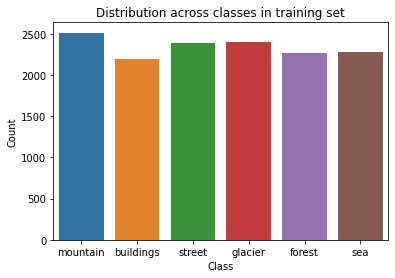

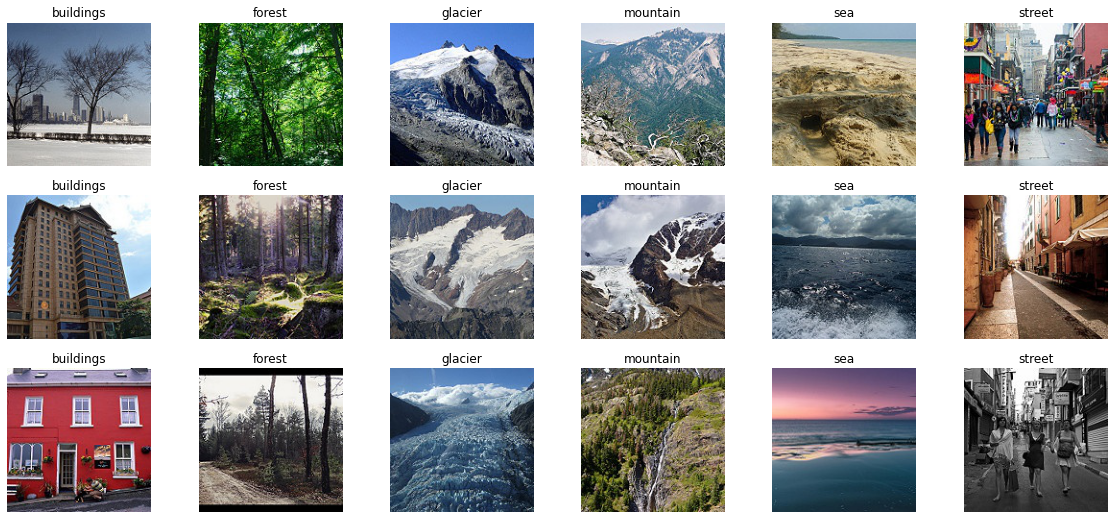

In [14]:
dirnames_train, fnames_train = read_image_names_class(dir_train)
train_summary = check_class_imbalance(fnames_train)
train_summary.head(10)
sns.barplot(data=train_summary, x = 'Class', y='Count').set_title("Distribution across classes in training set")
plot_sampled_images(dir_train, fnames_train)

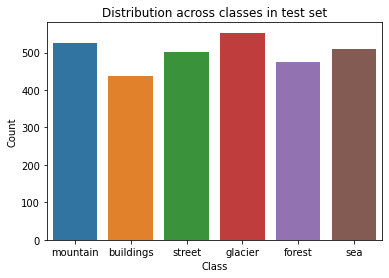

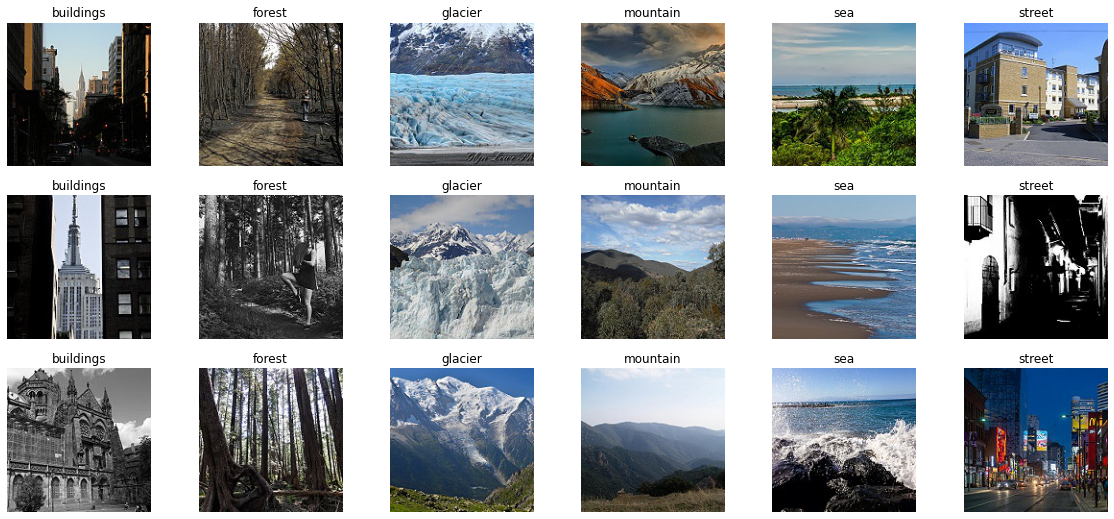

In [15]:
dirnames_test, fnames_test = read_image_names_class(dir_test)
test_summary = check_class_imbalance(fnames_test)
test_summary.head(10)

sns.barplot(data=test_summary, x = 'Class', y='Count').set_title("Distribution across classes in test set")

plot_sampled_images(dir_test, fnames_test)

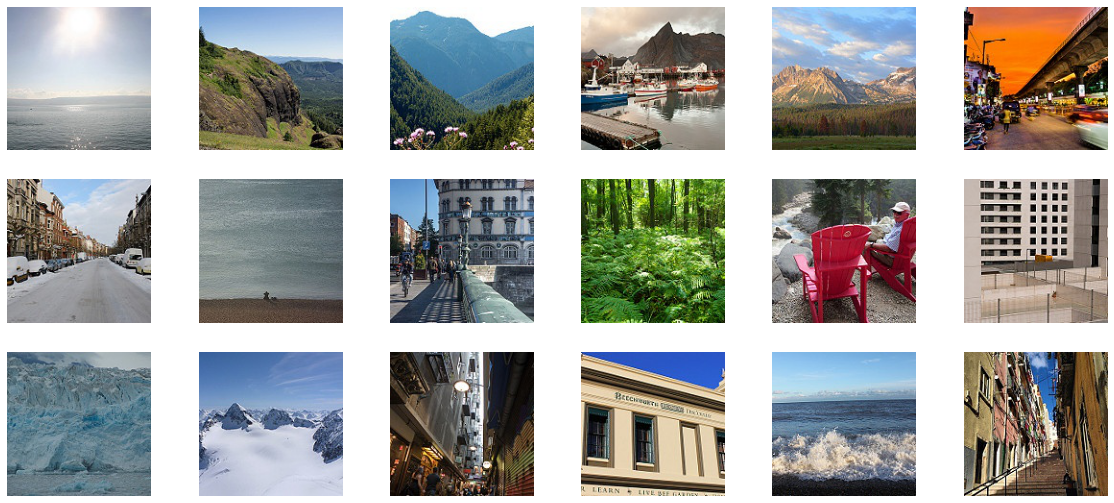

In [16]:
plot_sampled_prediction_images(dir_pred, fnames_pred)

In [17]:
batch = 32
shuff = True
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_train,
                                                               validation_split=0.2,  subset="training",
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= shuff, label_mode='categorical')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_train,
                                                               validation_split=0.2,  subset="validation",
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= shuff, label_mode='categorical')

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
train_model = True

In [22]:
if train_model:
    mod = tf.keras.models.Sequential([    
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (150,150,3)),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.3), width_factor=(0.1,0.3)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
                tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=12, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),    
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=8, kernel_size=(1,1), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),    
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),   
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=12, kernel_size=(5,5), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),      
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=12, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=6, activation='softmax')
                    ])
    
    mets = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), 
        tf.metrics.TrueNegatives(), tf.metrics.TruePositives(), tf.metrics.FalseNegatives(), tf.metrics.FalsePositives()]
    mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])
    
    earlystop = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3, restore_best_weights=True)
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-7)

In [24]:
if train_model:
    checkpoint = tf.keras.callbacks.ModelCheckpoint("C:/Users/HP/Desktop", monitor='val_acc', verbose=1, save_weights_only=True, mode='max')
    hist = mod.fit(train_ds, epochs=5, batch_size=batch, verbose=1, shuffle=shuff, validation_data=val_ds, callbacks=[earlystop, lr, checkpoint])

Epoch 1/5
351/351 [==============================] - ETA: 0s - loss: 1.1490 - accuracy: 0.5431
Epoch 1: saving model to C:/Users/HP/Desktop
351/351 [==============================] - 94s 268ms/step - loss: 1.1490 - accuracy: 0.5431 - val_loss: 1.2147 - val_accuracy: 0.5364 - lr: 0.0100
Epoch 2/5
351/351 [==============================] - ETA: 0s - loss: 1.0184 - accuracy: 0.6003
Epoch 2: saving model to C:/Users/HP/Desktop
351/351 [==============================] - 89s 253ms/step - loss: 1.0184 - accuracy: 0.6003 - val_loss: 1.2794 - val_accuracy: 0.5460 - lr: 0.0100
Epoch 3/5
351/351 [==============================] - ETA: 0s - loss: 0.9500 - accuracy: 0.6302
Epoch 3: saving model to C:/Users/HP/Desktop
351/351 [==============================] - 87s 248ms/step - loss: 0.9500 - accuracy: 0.6302 - val_loss: 0.8057 - val_accuracy: 0.6971 - lr: 0.0100
Epoch 4/5
351/351 [==============================] - ETA: 0s - loss: 0.9196 - accuracy: 0.6399
Epoch 4: saving model to C:/Users/HP/Desktop

In [25]:
mod.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 random_contrast_1 (RandomCo  (None, 150, 150, 3)      0         
 ntrast)                                                         
                                                                 
 random_flip_1 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 150, 150, 3)      0         
 tation)                                                         
                                                                 
 random_translation_1 (Rando  (None, 150, 150, 3)      0         
 mTranslation)                                                   
                                                      

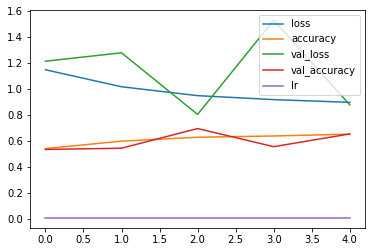

In [26]:
if train_model:
    for key in hist.history.keys():
        plt.plot(hist.history[key],label=key)
    plt.legend()
    # plt.ylim([0,1])

Found 14034 files belonging to 6 classes.
439/439 [==============================] - 11s 26ms/step - loss: 0.8808 - accuracy: 0.6570


[0.8807681202888489, 0.6569759249687195]

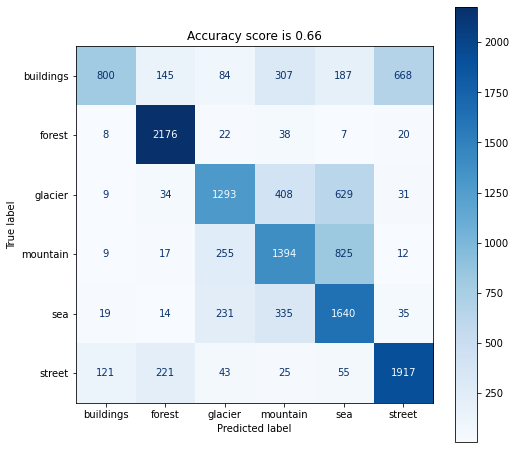

In [27]:
train_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_train,                                                   
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= False, label_mode='categorical')
y_true, y_pred = get_true_pred(mod, train_ds1)
plot_confMat(y_true, y_pred)

mod.evaluate(train_ds1)

Found 3000 files belonging to 6 classes.
94/94 [==============================] - 2s 22ms/step - loss: 0.8790 - accuracy: 0.6737


[0.87896329164505, 0.6736666560173035]

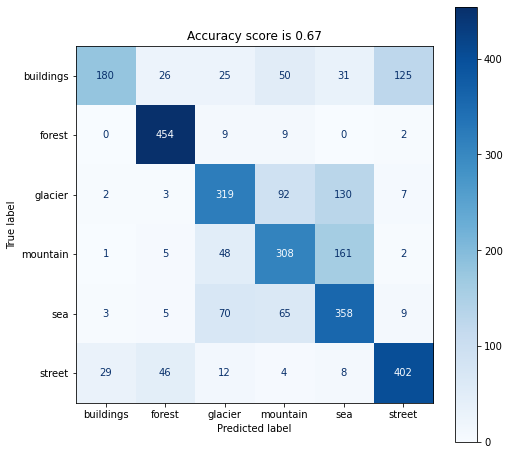

In [28]:
test_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_test, seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= False, label_mode='categorical')
# y_test = mod.predict(test_ds)
# tf.keras.utils.to_categorical(np.argmax(y_test,axis=1))
y_true, y_pred = get_true_pred(mod, test_ds1)
plot_confMat(y_true, y_pred)

mod.evaluate(test_ds1)